In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

<img src="./images/WindyGridworld.png" width="800"/>

In [3]:
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [4]:
env.action_space

Discrete(4)

In [5]:
env.observation_space

Discrete(70)

In [6]:
env.P[6]

{0: [(1.0, 6, -1.0, False)],
 1: [(1.0, 7, -1.0, False)],
 2: [(1.0, 6, -1.0, False)],
 3: [(1.0, 5, -1.0, False)]}

In [7]:
env.P[47]

{0: [(1.0, 17, -1.0, False)],
 1: [(1.0, 28, -1.0, False)],
 2: [(1.0, 37, -1.0, True)],
 3: [(1.0, 26, -1.0, False)]}

# SARSA

<img src="./images/SARSA1.png" width="800"/>


<img src="./images/SARSA2.png" width="800"/>

## $\epsilon$-greedy $\epsilon$-soft policy

<img src="./images/egreedy-esoft-policy.png" width="800"/>

## Algorithm

<img src="./images/SARSA3.png" width="800"/>

In [8]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        """
        Implement a egreedy-esoft policy
        """
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [9]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [10]:
Q, stats = sarsa(env, 2000)

Episode 2000/2000.

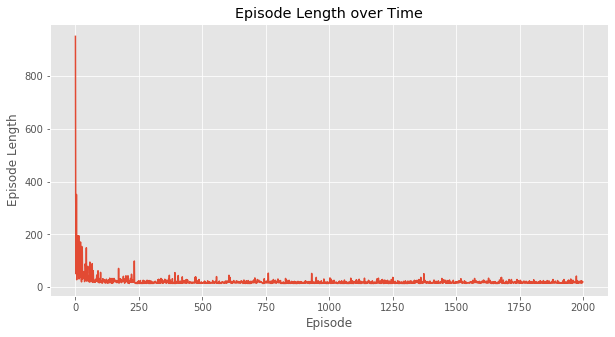

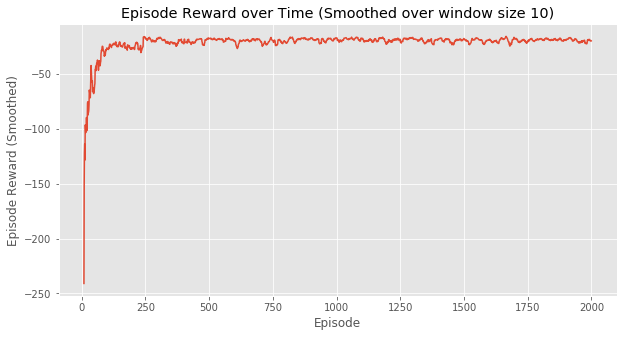

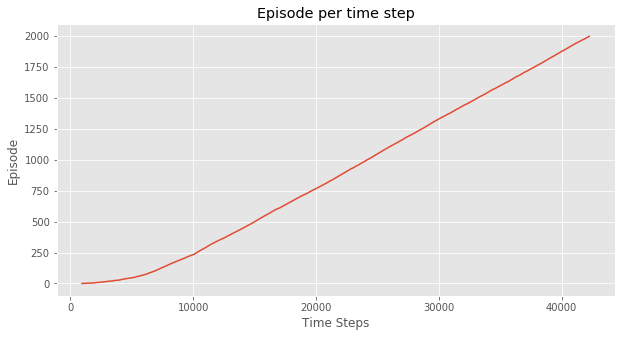

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats)

## Let's control using the learnt policy

In [12]:
from time import sleep
from IPython.display import clear_output
    
def choose_action(state):
    action = np.argmax(Q[state])
    return action

state = env.reset()

for t in range(30):
    clear_output(wait=True)
    env.render()
    action = choose_action(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    if done:
        print("Episode finished after {} timesteps \n".format(t+1))
        env.render()
        break
    print(t)
    sleep(1)
env.close()


o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

Episode finished after 18 timesteps 

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

